# Predicting Match Outcomes

This notebook combines the original **`train_model.py`** and **`analyze_model.py`** scripts into a single, step‑by‑step workflow.  
You can:
1. Load the pre‑processed match‑level CSV.  
2. Train an XGBoost classifier to predict which team will win.  
3. Evaluate the model and inspect performance metrics & visualisations.  

Feel free to tweak hyper‑parameters or add more analysis cells as you iterate.

## 0. Setup & Imports

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    roc_auc_score,
)

from xgboost import XGBClassifier, plot_importance


Below we define the paths to the dataset and the location where the trained model will be stored.

In [2]:
# 🔧 Update these paths to match your environment
CSV_PATH   = "matches.csv"              # ← output of your JSON→CSV conversion script
MODEL_PATH = "xgb_win_predictor.joblib"

## 1. Load the dataset

In [3]:
df = pd.read_csv(CSV_PATH)
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (16162, 1252)


,match_id,win,blue1_ch_12AssistStreakCount,blue1_ch_abilityUses,blue1_ch_acesBefore15Minutes,blue1_ch_alliedJungleMonsterKills,blue1_ch_baronBuffGoldAdvantageOverThreshold,blue1_ch_baronTakedowns,blue1_ch_blastConeOppositeOpponentCount,blue1_ch_bountyGold,...,red5_ch_twentyMinionsIn3SecondsCount,red5_ch_twoWardsOneSweeperCount,red5_ch_unseenRecalls,red5_ch_visionScoreAdvantageLaneOpponent,red5_ch_visionScorePerMinute,red5_ch_wardTakedowns,red5_ch_wardTakedownsBefore20M,red5_ch_wardsGuarded,red5_championId,red5_summonerLevel
0,4802683858,0,0.0,274.0,0.0,0.0,NaN,0.0,0.0,300.0,...,0.0,0.0,0.0,NaN,NaN,9.0,7.0,0.0,101,345
1,4802552142,1,0.0,189.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,2.0,1.0,0.0,412,292
2,4802524234,1,0.0,144.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,4.0,3.0,0.0,412,292
3,4798966587,0,0.0,168.0,0.0,4.0,NaN,0.0,0.0,675.0,...,0.0,0.0,0.0,NaN,NaN,5.0,5.0,0.0,902,482
4,4798945429,0,0.0,197.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,7.0,7.0,1.0,526,482


Extract the target label (`win`) and the feature matrix `X`.

In [4]:
y = df['win'].astype(int)
X = df.drop(columns=['win', 'match_id']).copy()

print('Class distribution:')
print(y.value_counts(normalize=True).rename('proportion').to_frame())


Class distribution:
     proportion
win            
1      0.506992
0      0.493008


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Assuming your DataFrame is named df and you want to scale all columns except 'win' and 'match_id'
columns_to_scale = [col for col in X.columns]
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

## 2. Train / validation split

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}")


Train size: 9697, Validation size: 6465


## 3. Train the XGBoost classifier

In [7]:
model = XGBClassifier(
    n_estimators=600,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    n_jobs=-1,
    tree_method='hist',
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)


[0]	validation_0-logloss:0.64653
[100]	validation_0-logloss:0.00668
[200]	validation_0-logloss:0.00151
[300]	validation_0-logloss:0.00109
[400]	validation_0-logloss:0.00098
[500]	validation_0-logloss:0.00092
[599]	validation_0-logloss:0.00087


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, ...)

### 3.1 Validation performance

In [8]:
preds_val = model.predict(X_val)
proba_val = model.predict_proba(X_val)[:, 1]

print(classification_report(y_val, preds_val, digits=3))
print('ROC-AUC:', roc_auc_score(y_val, proba_val).round(4))


              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3187
           1      1.000     1.000     1.000      3278

    accuracy                          1.000      6465
   macro avg      1.000     1.000     1.000      6465
weighted avg      1.000     1.000     1.000      6465

ROC-AUC: 1.0


### 3.2 Persist the trained model

In [9]:
joblib.dump(model, MODEL_PATH)
print(f'✅ Model saved to: {MODEL_PATH}')


✅ Model saved to: xgb_win_predictor.joblib


## 4. Analyse model on the full dataset

In [10]:
preds = model.predict(X)
proba = model.predict_proba(X)[:, 1]

print('\nClassification Report (full dataset):')
print(classification_report(y, preds, digits=3))



Classification Report (full dataset):
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      7968
           1      1.000     1.000     1.000      8194

    accuracy                          1.000     16162
   macro avg      1.000     1.000     1.000     16162
weighted avg      1.000     1.000     1.000     16162



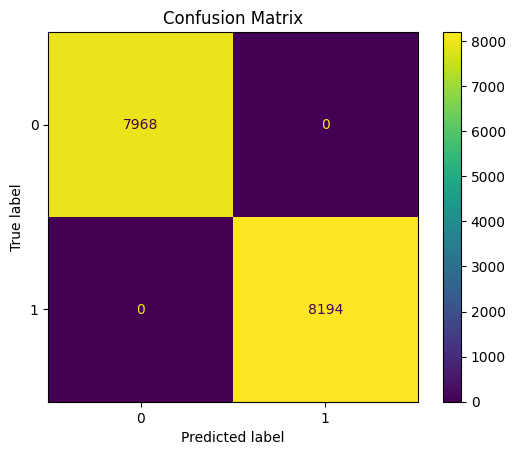

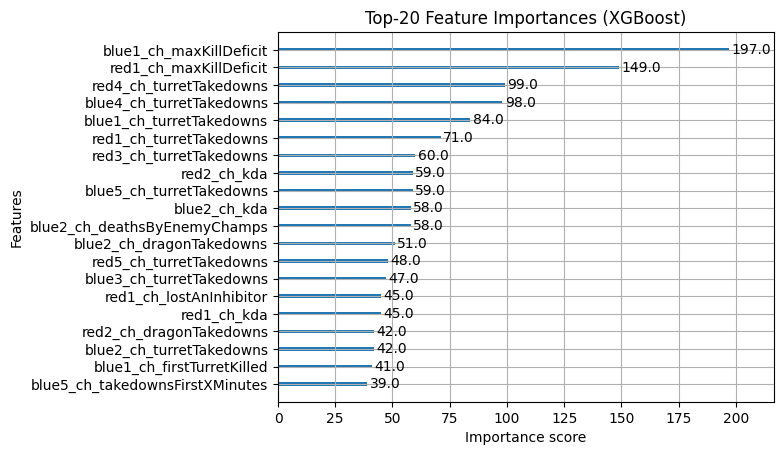

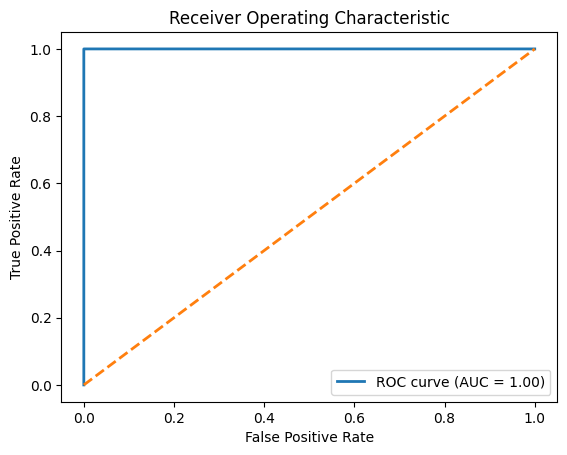

In [11]:
# Confusion Matrix
cm = confusion_matrix(y, preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix')
plt.show()

# Feature importance (top‑20)
plot_importance(model, max_num_features=20)
plt.title('Top‑20 Feature Importances (XGBoost)')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], linestyle='--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


 99%|===================| 16054/16162 [01:02<00:00]        

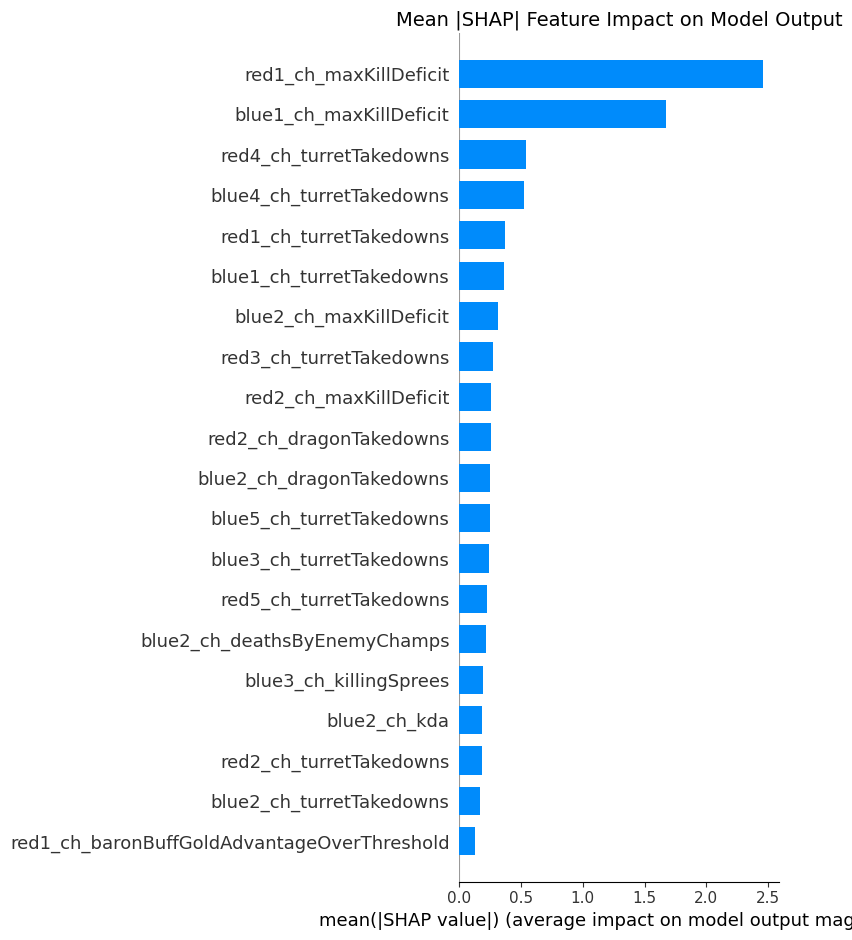

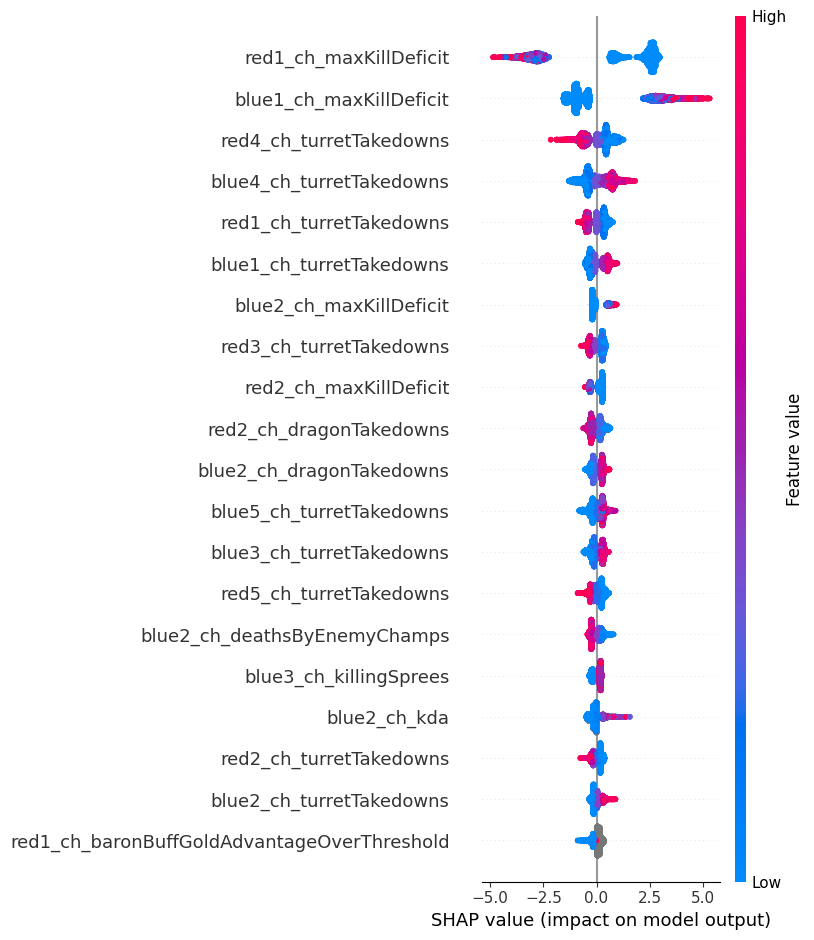

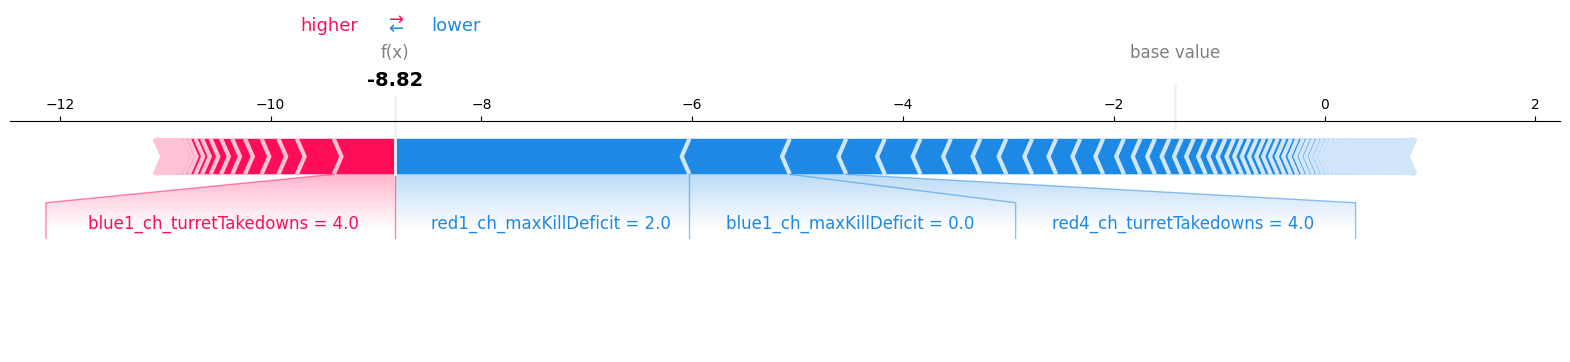

In [13]:
import shap
import matplotlib.pyplot as plt

background = shap.sample(X_train, 100, random_state=42)
explainer = shap.TreeExplainer(model, data=background, feature_perturbation="interventional")
shap_values = explainer.shap_values(X)   # <-- replace with the DataFrame you prefer

shap.summary_plot(
    shap_values, 
    X, 
    plot_type="bar", 
    show=False           # prevent auto‑display so we can tweak layout first
)
plt.title("Mean |SHAP| Feature Impact on Model Output", fontsize=14)
plt.tight_layout()
plt.show()

shap.summary_plot(
    shap_values, 
    X, 
    max_display=20       # show top‑20 features; adjust as needed
)

idx = 0
shap.force_plot(
    explainer.expected_value, 
    shap_values[idx, :], 
    X.iloc[idx, :],
    matplotlib=True
)